# Perceptron

This notebook demonstrates a **Perceptron** implementation from `rice_ml` on **scikit-learn built-in datasets**:

- **Binary classification:** `Breast Cancer Wisconsin (Diagnostic)` (`sklearn.datasets.load_breast_cancer`)  
  - Samples: 569, Features: 30, Classes: malignant/benign  
- **Multiclass classification:** `Iris` (`sklearn.datasets.load_iris`)  
  - Samples: 150, Features: 4 (we visualize with 2), Classes: setosa/versicolor/virginica

We will:
1. Load data from `sklearn.datasets`
2. Split into train/test using our NumPy utilities
3. Standardize using our NumPy `standardize`
4. Train `PerceptronClassifier`
5. Evaluate accuracy + visualize learning (mistakes per epoch) and decision regions (2D)



In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.decomposition import PCA

def add_repo_src_to_path(max_up: int = 8) -> None:
    cur = os.path.abspath(os.getcwd())
    for _ in range(max_up):
        candidate = os.path.join(cur, "src")
        if os.path.isdir(os.path.join(candidate, "rice_ml")):
            if candidate not in sys.path:
                sys.path.insert(0, candidate)
            return
        cur = os.path.abspath(os.path.join(cur, ".."))
    raise RuntimeError("Could not find 'src/rice_ml'. Run this notebook inside the repo, or install the package.")

add_repo_src_to_path()

from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.supervised_learning.perceptron import PerceptronClassifier


def standardize_with_params(X, params):
    """Apply (X - mean) / scale using params returned by standardize(..., return_params=True)."""
    mean = params["mean"]
    scale = params["scale"]
    return (X - mean) / scale


def confusion_matrix_np(y_true, y_pred, labels=None):
    """Simple confusion matrix using NumPy only."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    labels = np.asarray(labels)
    k = labels.size
    cm = np.zeros((k, k), dtype=int)
    for i, a in enumerate(labels):
        for j, b in enumerate(labels):
            cm[i, j] = int(np.sum((y_true == a) & (y_pred == b)))
    return cm, labels


## 1. Binary classification: Breast Cancer dataset

In [13]:
data = load_breast_cancer()
X = data["data"]
y = data["target"]  # 0=malignant, 1=benign (per sklearn encoding)
feature_names = data["feature_names"]
target_names = data["target_names"]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("class names:", target_names.tolist())
print("class counts:", {int(k): int(v) for k, v in zip(*np.unique(y, return_counts=True))})
print("feature names:", feature_names[:].tolist())


X shape: (569, 30)
y shape: (569,)
class names: ['malignant', 'benign']
class counts: {0: 212, 1: 357}
feature names: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [3]:
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    shuffle=True,
    stratify=y,
    random_state=42,
)

# Standardize using TRAIN statistics only
X_train_std, params = standardize(X_train, return_params=True)
X_test_std = standardize_with_params(X_test, params)

print("Train mean (approx):", np.round(X_train_std.mean(axis=0)[:5], 6))
print("Train std  (approx):", np.round(X_train_std.std(axis=0)[:5], 6))
print("Test  mean (approx):", np.round(X_test_std.mean(axis=0)[:5], 6))
print("Test  std  (approx):", np.round(X_test_std.std(axis=0)[:5], 6))


Train mean (approx): [ 0.  0.  0.  0. -0.]
Train std  (approx): [1. 1. 1. 1. 1.]
Test  mean (approx): [ 3.3700e-02 -8.5000e-05  3.1855e-02  3.2082e-02 -7.7555e-02]
Test  std  (approx): [1.026018 0.902139 1.029416 1.006219 1.102419]


In [4]:
# Train perceptron (binary)
clf_bin = PerceptronClassifier(
    max_iter=500,
    learning_rate=1.0,
    fit_intercept=True,
    shuffle=True,
    tol=0,
    n_iter_no_change=10,
    random_state=0,
).fit(X_train_std, y_train)

train_acc = clf_bin.score(X_train_std, y_train)
test_acc = clf_bin.score(X_test_std, y_test)

print("Binary Perceptron:")
print("  n_iter_:", clf_bin.n_iter_)
print("  train acc:", train_acc)
print("  test  acc:", test_acc)
print("  final mistakes:", int(clf_bin.mistakes_[-1]) if clf_bin.mistakes_ is not None and clf_bin.mistakes_.size else None)

y_pred_test = clf_bin.predict(X_test_std)
cm, labels = confusion_matrix_np(y_test, y_pred_test, labels=np.array([0, 1]))
print("\nConfusion matrix (test): rows=true, cols=pred, labels=[0,1]")
print(cm)


Binary Perceptron:
  n_iter_: 262
  train acc: 1.0
  test  acc: 0.971830985915493
  final mistakes: 0

Confusion matrix (test): rows=true, cols=pred, labels=[0,1]
[[51  2]
 [ 2 87]]


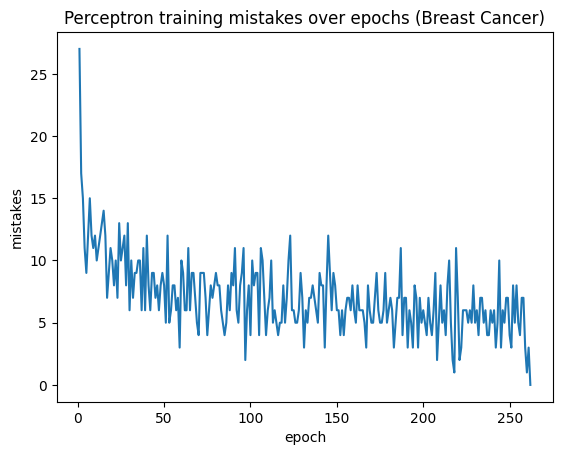

In [5]:
# Learning curve: mistakes per epoch
plt.figure()
plt.plot(np.arange(1, len(clf_bin.mistakes_) + 1), clf_bin.mistakes_)
plt.xlabel("epoch")
plt.ylabel("mistakes")
plt.title("Perceptron training mistakes over epochs (Breast Cancer)")
plt.show()


### 1.1 Decision regions (2D visualization via PCA)

The breast cancer dataset has 30 features, so we use **PCA to 2D** purely for visualization.  
We train a separate Perceptron in the PCA space to draw the decision boundary.


In [6]:
# PCA to 2D for visualization (fit on TRAIN only)
pca = PCA(n_components=2, random_state=0)
Z_train = pca.fit_transform(X_train_std)
Z_test  = pca.transform(X_test_std)

clf_bin_2d = PerceptronClassifier(
    max_iter=300,
    learning_rate=1.0,
    fit_intercept=True,
    shuffle=True,
    tol=0,
    n_iter_no_change=10,
    random_state=0,
).fit(Z_train, y_train)

print("PCA(2D) Perceptron:")
print("  train acc:", clf_bin_2d.score(Z_train, y_train))
print("  test  acc:", clf_bin_2d.score(Z_test, y_test))
print("  explained variance ratio:", np.round(pca.explained_variance_ratio_, 4).tolist())


PCA(2D) Perceptron:
  train acc: 0.9391100702576113
  test  acc: 0.9366197183098591
  explained variance ratio: [0.4283, 0.1978]


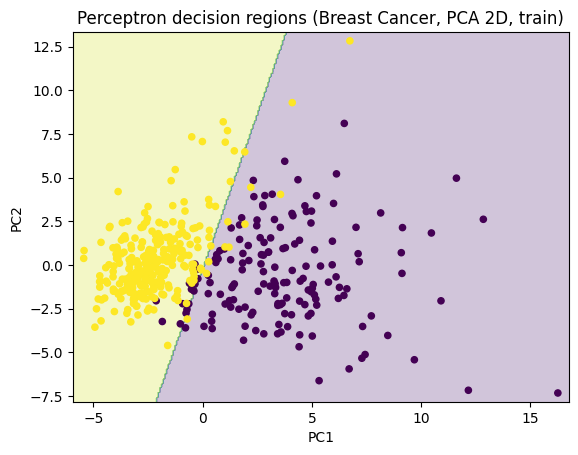

In [7]:
# Plot decision regions in PCA space (train set)
z1_min, z1_max = Z_train[:, 0].min() - 0.5, Z_train[:, 0].max() + 0.5
z2_min, z2_max = Z_train[:, 1].min() - 0.5, Z_train[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(z1_min, z1_max, 300),
    np.linspace(z2_min, z2_max, 300),
)
grid = np.c_[xx.ravel(), yy.ravel()]
pred_grid = clf_bin_2d.predict(grid).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, pred_grid, alpha=0.25)
plt.scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Perceptron decision regions (Breast Cancer, PCA 2D, train)")
plt.show()


## 2. Multiclass classification: Iris dataset

We use a 2D feature subset for a clean visualization:
- petal length (cm)
- petal width (cm)


In [8]:
iris = load_iris()
X_iris = iris["data"]
y_iris = iris["target"]
iris_feature_names = iris["feature_names"]
iris_target_names = iris["target_names"]

# Use 2D features for visualization
feat_idx = [2, 3]  # petal length, petal width
X2 = X_iris[:, feat_idx]
feat_names_2d = [iris_feature_names[i] for i in feat_idx]

print("X2 shape:", X2.shape)
print("y shape:", y_iris.shape)
print("2D features:", feat_names_2d)
print("class names:", iris_target_names.tolist())
print("class counts:", {int(k): int(v) for k, v in zip(*np.unique(y_iris, return_counts=True))})


X2 shape: (150, 2)
y shape: (150,)
2D features: ['petal length (cm)', 'petal width (cm)']
class names: ['setosa', 'versicolor', 'virginica']
class counts: {0: 50, 1: 50, 2: 50}


In [9]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y_iris,
    test_size=0.25,
    shuffle=True,
    stratify=y_iris,
    random_state=42,
)

X_train2_std, params2 = standardize(X_train2, return_params=True)
X_test2_std = standardize_with_params(X_test2, params2)

print("Train mean (approx):", np.round(X_train2_std.mean(axis=0), 6))
print("Train std  (approx):", np.round(X_train2_std.std(axis=0), 6))
print("Test  mean (approx):", np.round(X_test2_std.mean(axis=0), 6))
print("Test  std  (approx):", np.round(X_test2_std.std(axis=0), 6))


Train mean (approx): [-0.  0.]
Train std  (approx): [1. 1.]
Test  mean (approx): [ 0.004373 -0.0367  ]
Test  std  (approx): [0.970134 0.926649]


In [10]:
clf_multi = PerceptronClassifier(
    max_iter=200,
    learning_rate=1.0,
    fit_intercept=True,
    shuffle=True,
    tol=0,
    n_iter_no_change=10,
    random_state=0,
).fit(X_train2_std, y_train2)

train_acc2 = clf_multi.score(X_train2_std, y_train2)
test_acc2 = clf_multi.score(X_test2_std, y_test2)

print("Multiclass Perceptron (Iris 2D):")
print("  n_iter_:", clf_multi.n_iter_)
print("  train acc:", train_acc2)
print("  test  acc:", test_acc2)

y_pred2 = clf_multi.predict(X_test2_std)
cm2, labels2 = confusion_matrix_np(y_test2, y_pred2, labels=np.array([0, 1, 2]))
print("\nConfusion matrix (test): rows=true, cols=pred, labels=[0,1,2]")
print(cm2)


Multiclass Perceptron (Iris 2D):
  n_iter_: 200
  train acc: 0.9385964912280702
  test  acc: 0.9722222222222222

Confusion matrix (test): rows=true, cols=pred, labels=[0,1,2]
[[12  0  0]
 [ 0 11  1]
 [ 0  0 12]]


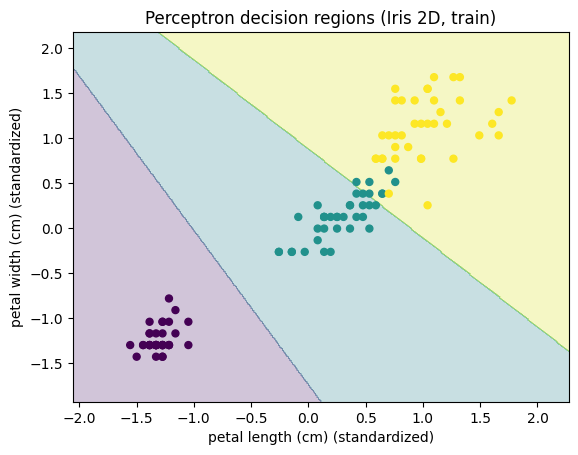

In [11]:
# Decision regions for Iris (train set)
x1_min, x1_max = X_train2_std[:, 0].min() - 0.5, X_train2_std[:, 0].max() + 0.5
x2_min, x2_max = X_train2_std[:, 1].min() - 0.5, X_train2_std[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x1_min, x1_max, 400),
    np.linspace(x2_min, x2_max, 400),
)
grid = np.c_[xx.ravel(), yy.ravel()]
pred = clf_multi.predict(grid).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, pred, alpha=0.25)
plt.scatter(X_train2_std[:, 0], X_train2_std[:, 1], c=y_train2, s=25)
plt.xlabel(feat_names_2d[0] + " (standardized)")
plt.ylabel(feat_names_2d[1] + " (standardized)")
plt.title("Perceptron decision regions (Iris 2D, train)")
plt.show()


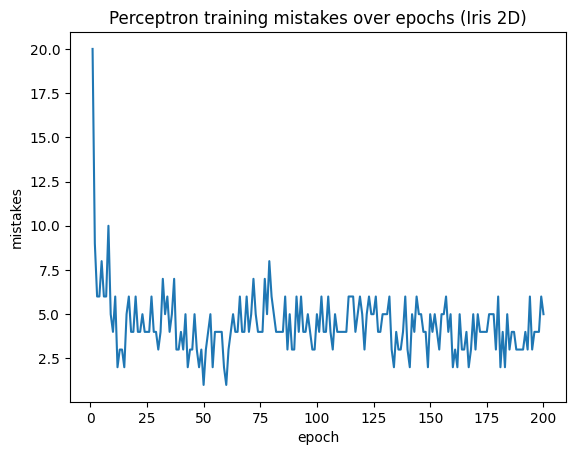

In [12]:
# Learning curve: mistakes per epoch (Iris)
plt.figure()
plt.plot(np.arange(1, len(clf_multi.mistakes_) + 1), clf_multi.mistakes_)
plt.xlabel("epoch")
plt.ylabel("mistakes")
plt.title("Perceptron training mistakes over epochs (Iris 2D)")
plt.show()


## Conclusion

- **Perceptron** is a fast **linear classifier** trained with **mistake-driven updates**.  
  It learns a decision boundary directly from classification errors (unlike Logistic Regression, it does **not** produce calibrated probabilities).

### 1) Breast Cancer (binary, standardized, full feature space)

- The model converged in **262 epochs** and reached **0 training mistakes**, with:
  - **train accuracy = 1.000**
  - **test accuracy  = 0.972**

- The **mistakes vs epoch** curve drops sharply at the beginning and then fluctuates at a low level before reaching zero.  
  This is consistent with perceptron training: once the weights become “good enough”, only a small fraction of samples keep triggering updates.

- The test confusion matrix shows only **4 total errors**:
  - 2 false positives and 2 false negatives  
  which indicates strong generalization on this split, even though perfect test accuracy is not expected.

### 2) Breast Cancer (PCA 2D visualization)

- When we project to only **2 principal components**, performance drops to:
  - **train accuracy ≈ 0.939**
  - **test accuracy  ≈ 0.937**

- This is expected: the first two PCs explain about  
  **0.4283 + 0.1978 ≈ 0.626** (≈62.6%) of the variance, so we lose information that can help classification.

- The decision-region plot in PC space shows a clean **linear boundary**, but some overlap remains after dimensionality reduction.

### 3) Iris (multiclass, 2D petal features)

- Using only **petal length** and **petal width** (standardized), the multiclass perceptron achieved:
  - **train accuracy ≈ 0.939**
  - **test accuracy  ≈ 0.972**

- The confusion matrix indicates:
  - **setosa** is perfectly separated,
  - the only mistake is **one versicolor predicted as virginica**, which matches the well-known partial overlap between those two classes in simple 2D feature views.

### Key takeaways

- Perceptron works best when the classes are **approximately linearly separable** in the chosen feature space.
- **Standardization** improves training stability and makes the update dynamics more consistent.
- **Dimensionality reduction (PCA 2D)** is great for visualization, but it can reduce accuracy because it discards useful information.

Next step: we can compare against **Logistic Regression** on the same datasets to see how a probabilistic linear model behaves (especially under overlap and regularization), or move to a **non-linear model** if we want curved decision boundaries.

